In [1]:
import os, time, random, logging
import cv2
import numpy as np
import PySimpleGUI as sg
from pathlib import Path
#import mtcnn

#import pandas as pd
import tensorflow as tf
print("tf",tf.version.VERSION)
#os.system("cat /usr/local/cuda/version.txt")
#os.system("nvcc --version\n")
os.system("conda list | grep -E 'tensorflow|cudnn|cudatoolkit|numpy'")

from tensorflow import keras
from keras import backend as K
#from keras import models, layers, backend as K
#from keras.layers import Activation
from tensorflow.keras.callbacks import ModelCheckpoint
#from tensorflow.keras.utils import get_custom_objects
#from keras.utils.generic_utils import get_custom_objects
from tqdm.keras import TqdmCallback

import neptune
from neptune.integrations.tensorflow_keras import NeptuneCallback

import auxua

tf 2.2.0
cudatoolkit               10.1.243            h8cb64d8_11    conda-forge
cudnn                     7.6.5.32             hc0a50b0_1    conda-forge
neptune-tensorflow-keras  2.1.0              pyhd8ed1ab_0    conda-forge
numpy                     1.19.5           py38hc896f84_4  
numpy-base                1.19.5           py38h21a3de8_4  
tensorflow                2.2.0           gpu_py38hb782248_0    anaconda
tensorflow-base           2.2.0           gpu_py38h83e3d50_0    anaconda
tensorflow-estimator      2.6.0            py38h709712a_0    conda-forge
tensorflow-gpu            2.2.0                h0d30ee6_0    anaconda


/home/jtstudents/anaconda3/envs/zugpu/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/jtstudents/anaconda3/envs/zugpu/lib/python3.8/site-packages/neptune/internal/backends/hosted_client.py:48: NeptuneDeprecationWarning: The 'neptune-client' package has been deprecated and will be removed in the future. Install the 'neptune' package instead. For more, see https://docs.neptune.ai/setup/upgrading/
  from neptune.version import version as neptune_client_version


In [2]:
""" PATH VAR """

ssh4wd = True#False#
zu = True#False#

if ssh4wd:
    base_vigia_dir = "/raid/DATASETS/.zuble/vigia"

    server_trainame_folder = '/raid/DATASETS/anomaly/XD_Violence/training/'
    server_testname_folder = '/raid/DATASETS/anomaly/XD_Violence/testing'
else:
    base_vigia_dir = "/media/jtstudents/HDD/.zuble/vigia"

    #server_trainame_folder = '/home/zhen/Documents/Remote/raid/DATASETS/anomaly/UCF_Crimes/Videos'
    server_trainame_folder = '/media/jtstudents/HDD/.zuble/xdviol/train'
    server_testname_folder = '/media/jtstudents/HDD/.zuble/xdviol/test'
    
if zu:
    model_path = base_vigia_dir+'/zu++/model/model/'
    ckpt_path = base_vigia_dir+'/zu++/model/ckpt/'
    hist_path = base_vigia_dir+'/zu++/model/hist/'

    rslt_path = base_vigia_dir+'/zu++/model/rslt/'
    weights_path = base_vigia_dir+'/zu++/model/weights/'
else:
    weights_path = base_vigia_dir+"/zhen++/parameters_saved"
    rslt_path = base_vigia_dir+'zhen++/parameters_results/original_bt'

In [ ]:
''' GPU CONFIGURATION
    https://www.tensorflow.org/guide/gpu '''

#https://www.tensorflow.org/api_docs/python/tf/config/experimental/set_memory_growth

def set_memory_growth():
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        print("\nAvaiable GPU's",gpus)
        try:
            # Currently, memory growth needs to be the same across GPUs
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            
            logical_gpus = tf.config.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        except RuntimeError as e:
            # Memory growth must be set before GPUs have been initialized
            print(e)

def set_tf_loglevel(level):
    if level >= logging.FATAL:
        os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
    if level >= logging.ERROR:
        os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
    if level >= logging.WARNING:
        os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
    else:
        os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'
    logging.getLogger('tensorflow').setLevel(level)

set_tf_loglevel(logging.ERROR)
tf.debugging.set_log_device_placement(False) #Enabling device placement logging causes any Tensor allocations or operations to be printed.

os.environ["CUDA_VISIBLE_DEVICES"]="0"
gpus = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpus));
for i in range(len(gpus)) :print(str(gpus[i]))

In [3]:
''' NEPTUNE 
    https://docs.neptune.ai/integrations/keras/
'''

with open('/raid/DATASETS/.zuble/.nept', 'r') as file:nept = file.read()
run = neptune.init_run( api_token=nept, project="vigia/base")
project = neptune.init_project(project="vigia/base", api_token=nept)

/tmp/ipykernel_3842/2133515314.py:6: NeptuneWarning: To avoid unintended consumption of logging hours during interactive sessions, the following monitoring options are disabled unless set to 'True' when initializing the run: 'capture_stdout', 'capture_stderr', and 'capture_hardware_metrics'.
  run = neptune.init_run( api_token=nept, project="vigia/base")


https://app.neptune.ai/vigia/base/e/BASE-62
https://app.neptune.ai/vigia/base/


In [ ]:
"""" TEST & TRAIN FILES """

def test_files(onev = 0):
    """
    GENERATE LIST of train FILES
    """
    test_fn, test_normal_fn, test_abnormal_fn = [],[],[]
    test_labels, test_normal_labels, test_abnormal_labels = [],[],[]
    
    
    #makes sure that nept log are clear
    try:del run["test/data_info"]
    except:run["test/data_info"]

    #all test files
    if onev == 0:
        for root, dirs, files in os.walk(server_testname_folder):
            for file in files:
                if file.find('.mp4') != -1:
                    if 'label_A' in file:
                        test_normal_fn.append(os.path.join(root, file))
                        test_normal_labels.append(0)
                        run["test/data_info/test_normal"].append(str((file,0)))
                    else:
                        test_abnormal_fn.append(os.path.join(root, file))
                        test_abnormal_labels.append(1)    
                        run["test/data_info/test_abnormal"].append(str((file,1)))          

        test_labels = test_normal_labels + test_abnormal_labels                
        test_fn = test_normal_fn + test_abnormal_fn
        for i in range(len(test_fn)): run["test/data_info/test"].append(test_fn[i])
        
    #only onev random files
    else :
        test_abn_fn = [x for x in os.listdir(server_testname_folder) if 'label_A' not in x]
        test_nor_fn = [x for x in os.listdir(server_testname_folder) if 'label_A' in x]
        
        onev_abnor = int(onev/2)
        while True: 
            ap = random.choice(test_abn_fn) 
            if ap not in test_fn: 
                test_fn.append(server_testname_folder+"/"+ap)
                test_labels.append(1)
                if len(test_fn) == onev_abnor: 
                    break 
        while True: 
            ap = random.choice(test_nor_fn) 
            if ap not in test_fn: 
                test_fn.append(server_testname_folder+"/"+ap)
                test_labels.append(0)
                if len(test_fn) == onev: 
                    break    
    
    
    run["test/data_info/test_shape"] = "total_fn "+str(np.shape(test_fn)[0])+"\ntotal_labels "+str(np.shape(test_labels)[0])+\
                                        "\nnormal_fn "+str(np.shape(test_normal_fn)[0])+"\nnormal_labels "+str(np.shape(test_normal_labels)[0])+\
                                        "\nabnormal_fn "+str(np.shape(test_abnormal_fn)[0])+"\nabnormal_labels "+str(np.shape(test_abnormal_labels)[0])
    
    print("\ntest_fn",np.shape(test_fn),"\ntest_normal_fn",np.shape(test_normal_fn),"\ntest_abnormal_fn",np.shape(test_abnormal_fn))
    print("\ntest_labels",np.shape(test_labels),"\ntest_normal_labels",np.shape(test_normal_labels),"\ntest_abnormal_labels",np.shape(test_abnormal_labels))
    print('\n-------------------')
    return test_fn , test_normal_fn , test_abnormal_fn , test_labels 

def train_files():
    """
    GENERATING LIST of TRAIN FILES
    """
    train_fn, train_normal_fn, train_abnormal_fn = [],[],[]
    train_labels, train_normal_labels, train_abnormal_labels = [],[],[]

    #makes sure that neptlog are clear
    try:del run["train/data_info"]
    except:run["train/data_info"]

    for root, dirs, files in os.walk(server_trainame_folder):
        for file in files:
            if file.find('.mp4') != -1:
                train_fn.append(os.path.join(root, file))
                run["train/data_info/train"].append(file)

                if 'label_A' in file:
                    train_normal_fn.append(os.path.join(root, file))
                    train_normal_labels.append(0)
                    run["train/data_info/train_normal"].append(str((file,0)))

                else:
                    train_abnormal_fn.append(os.path.join(root, file))
                    train_abnormal_labels.append(1)
                    run["train/data_info/train_abnormal"].append(str((file,1)))

    # this way labels and video_fn are in sync , no need of labels in training tho
    #train_fn2 = train_normal_fn + train_abnormal_fn
    #train_labels = train_normal_labels + train_abnormal_labels 
    
    run["train/data_info/train_shape"] = str("total "+str(np.shape(train_fn)[0])+"\nabnormal "+str(np.shape(train_abnormal_fn)[0])+"\nnormal "+str(np.shape(train_normal_fn)[0]))

    print("\ntrain_fn",np.shape(train_fn),"\ntrain_normal_fn",np.shape(train_normal_fn),"\ntrain_abnormal_fn",np.shape(train_abnormal_fn))
    #print("\ny_train_labels",np.shape(y_train_labels),"\ny_train_norm",np.shape(y_train_norm),"\ny_train_abnor",np.shape(y_train_abnor))

    return train_fn , train_abnormal_fn , train_normal_fn

def nept_load_dataset():
    
    #run["dataset/train"].track_files(server_trainame_folder,wait=True)
    
    
    del project["dataset"]
    
    for i in range(len(train_normal_fn)): project["dataset/train_normal/"+os.path.basename(train_normal_fn[i])].upload(train_normal_fn[i])
    for i in range(len(train_abnormal_fn)): project["dataset/train_abnormal/"+os.path.basename(train_normal_fn[i])].upload(train_abnormal_fn[i])
    
    for i in range(len(test_normal_fn)): project["dataset/test_normal/"+os.path.basename(train_normal_fn[i])].upload(test_normal_fn[i])
    for i in range(len(test_abnormal_fn)): project["dataset/test_abnormal/"+os.path.basename(train_normal_fn[i])].upload(test_abnormal_fn[i])
    

test_fn , test_abnormal_fn , test_normal_fn , test_labels = test_files()
train_fn , train_abnormal_fn, train_normal_fn = train_files()

update_index = range(0, len(train_fn))

In [ ]:
""" INPUT DATA"""

in_height = 120; in_width = 160

def input_video_data(file_name):
    print("\n\nINPUT_VIDEO_DATA\n")
    #file_name = 'C:\\Bosch\\Anomaly\\training\\videos\\13_007.avi'
    #file_name = '/raid/DATASETS/anomaly/UCF_Crimes/Videos/Training_Normal_Videos_Anomaly/Normal_Videos308_x264.mp4'
    video = cv2.VideoCapture(file_name)
    total_frame = video.get(cv2.CAP_PROP_FRAME_COUNT)
    #mtcnn_detector = mtcnn.mtcnn.MTCNN()
    #print(file_name + '  ' + str(total_frame))
    divid_no = 1
    
    frame_max = train_config["frame_max"]
    
    # define the nmbers of batchs to divid atual video (divid_no)
    if total_frame > int(frame_max):
        total_frame_int = int(total_frame)
        if total_frame_int % int(frame_max) == 0:
            divid_no = int(total_frame / int(frame_max))
        else:
            divid_no = int(total_frame / int(frame_max)) + 1
        
    batch_no = 0
    batch_frames = []
    batch_frames_flip = []
    counter = 0
    if 'Normal' in file_name:
        print("\n\nNORMAL\n\n")
        if divid_no != 1:
            slice_no = int(random.random()*divid_no)
            passby = 0
            if slice_no != divid_no - 1:
                while video.isOpened and passby < int(frame_max) * slice_no:
                    passby += 1
                    success, image = video.read()
                    if success == False:
                        break
            else:
                while video.isOpened and passby < total_frame - int(frame_max):
                    passby += 1
                    success, image = video.read()
                    if success == False:
                        break

    while video.isOpened:               
        success, image = video.read()
        if success == False:
            break
            
        #ratio = image.shape[0] / image.shape[1]
        #print(str(image.shape[0])+ ' ' + str(image.shape[1]))
        #image = cv2.resize(image, (800, int(800*ratio)))
        #print(image.shape)
        #faces = face_detector.detectMultiScale(image,1.1,8)
        '''
        faces = mtcnn_detector.detect_faces(image)
        
        for face in faces:
            (x,y,w,h) = face['box']
            #print(face)
            cv2.rectangle(image,(x,y), (x+w,y+h), (255,255,0), 2)
            cv2.putText(image, str(face['confidence'])[:4], (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (36,255,12), 1)
        '''
        image = cv2.resize(image, (in_width, in_height))
        image_flip = cv2.flip(image, 1)
        
        image_array = np.array(image)/255.0
        image_array_flip = np.array(image_flip)/255.0
        
        batch_frames.append(image_array)
        batch_frames_flip.append(image_array_flip)
        
        counter += 1
        if counter > int(frame_max):
            break
            
    video.release()
    batch_frames = np.array(batch_frames)
    #print(batch_frames.shape)
        
    return np.expand_dims(batch_frames,0), np.expand_dims(batch_frames_flip, 0), total_frame

def generate_input():
    #has_visited = [0 for i in range(len(train_fn))]
    
    print("\n\nGENERATE_INPUT\n")
    loop_no = 0
    while 1:
        index = update_index[loop_no]
        loop_no += 1
        if loop_no == len(train_fn):
            loop_no = 0
            
        #index = 0
        batch_frames, batch_frames_flip, total_frames = input_video_data(train_fn[index])
        print("\n\ttrain_fn[",index,"]=",train_fn[index],"\ntotal_frames=",total_frames,"\nbatch_frames.shape=",batch_frames.shape)
        #if batch_frames.ndim != 5:
        #   break
        
        # GENERATORS    
        #       a kind of iterators that can only iterate over once
        #       NO store of values in memory
        # YIELD 
        #       like a return, except the function will return a generator
        
        '''
        if 'Abuse' in train_fn[index]:
            yield batch_frames,  np.array([np.array([1,0,0,0,0,0,0,0,0,0,0,0,0,0])])
        elif 'Arrest' in train_fn[index]:
            yield batch_frames,  np.array([np.array([0,1,0,0,0,0,0,0,0,0,0,0,0,0])])
        elif 'Arson' in train_fn[index]:
            yield batch_frames,  np.array([np.array([0,0,1,0,0,0,0,0,0,0,0,0,0,0])])
        elif 'Assault' in train_fn[index]:
            yield batch_frames,  np.array([np.array([0,0,0,1,0,0,0,0,0,0,0,0,0,0])]) 
        elif 'Burglary' in train_fn[index]:
            yield batch_frames,  np.array([np.array([0,0,0,0,1,0,0,0,0,0,0,0,0,0])]) 
        elif 'Explosion' in train_fn[index]:
            yield batch_frames,  np.array([np.array([0,0,0,0,0,1,0,0,0,0,0,0,0,0])])        
        elif 'Fighting' in train_fn[index]:
            yield batch_frames,  np.array([np.array([0,0,0,0,0,0,1,0,0,0,0,0,0,0])]) 
        elif 'RoadAccidents' in train_fn[index]:
            yield batch_frames,  np.array([np.array([0,0,0,0,0,0,0,1,0,0,0,0,0,0])]) 
        elif 'Robbery' in train_fn[index]:
            yield batch_frames,  np.array([np.array([0,0,0,0,0,0,0,0,1,0,0,0,0,0])]) 
        elif 'Shooting' in train_fn[index]:
            yield batch_frames,  np.array([np.array([0,0,0,0,0,0,0,0,0,1,0,0,0,0])]) 
        elif 'Shoplifting' in train_fn[index]:
            yield batch_frames,  np.array([np.array([0,0,0,0,0,0,0,0,0,0,1,0,0,0])]) 
        elif 'Stealing' in train_fn[index]:
            yield batch_frames,  np.array([np.array([0,0,0,0,0,0,0,0,0,0,0,1,0,0])])
        elif 'Normal' in train_fn[index]:
            yield batch_frames,  np.array([np.array([0,0,0,0,0,0,0,0,0,0,0,0,1,0])]) 
        elif 'Vandalism' in train_fn[index]:
            yield batch_frames,  np.array([np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,1])]) 
        '''
        
        #batch_frames
        if 'label_A' in train_fn[index]:
            yield batch_frames, np.array([0])   #normal
        else:
            yield batch_frames, np.array([1])   #abnormal

        #batch_frames_flip
        if 'label_A' in train_fn[index]:
            yield batch_frames_flip, np.array([0])  #normal
        else:
            yield batch_frames_flip, np.array([1])  #abnormal
    
    print("loop_no=",loop_no)


def input_test_video_data(file_name,config,batch_no=0):
    #file_name = 'C:\\Bosch\\Anomaly\\training\\videos\\13_007.avi'
    #file_name = '/raid/DATASETS/anomaly/UCF_Crimes/Videos/Training_Normal_Videos_Anomaly/Normal_Videos308_x264.mp4'
    video = cv2.VideoCapture(file_name)
    total_frame = video.get(cv2.CAP_PROP_FRAME_COUNT)
    fps = video.get(cv2.CAP_PROP_FPS)
    #mtcnn_detector = mtcnn.mtcnn.MTCNN()
    divid_no = 1
    frame_max = config["frame_max"]
    batch_type = config["batch_type"]
    
    # define the nmbers of batchs to divid atual video (divid_no)
    if total_frame > int(frame_max):
        total_frame_int = int(total_frame)
        if total_frame_int % int(frame_max) == 0:
            divid_no = int(total_frame / int(frame_max))
        else:
            divid_no = int(total_frame / int(frame_max)) + 1


    #updates the start frame to 0,frame_max*1,frame_max*2... excluding the last batch
    passby = 0
    if batch_no != divid_no - 1:
        while video.isOpened and passby < int(frame_max) * batch_no:
            passby += 1
            success, image = video.read()
            if success == False:
                break
            
    #updates the last batch starting frame 
    else:
        if batch_type==1:
            #print("1")
            while video.isOpened and passby < total_frame - int(frame_max):
                passby += 1
                success, image = video.read()
                if success == False:
                    break
        #last batch must have >= frame_max/10 otherwise it falls back to batch_type 1
        if batch_type==2 and total_frame - (int(frame_max) * batch_no) >= int(frame_max)*0.1:
            #print("2")
            while video.isOpened and passby < int(frame_max) * batch_no:
                passby += 1
                success, image = video.read()
                if success == False:
                    break
        else:
            while video.isOpened and passby < total_frame - int(frame_max):
                passby += 1
                success, image = video.read()
                if success == False:
                    break

            
    batch_frames, batch_imgs = [], []
    counter = 0
    
    while video.isOpened:               
        success, image = video.read()
        if success == False:
            break
        batch_imgs.append(image)
        
        image_rsz = cv2.resize(image, (in_width, in_height))
        image_array = np.array(image_rsz)/255.0 #normalize
        batch_frames.append(image_array)
        
        counter += 1
        if counter > int(frame_max):
            break
            
    video.release()
    
    #batch_frames_tensor = tf.convert_to_tensor(batch_frames)
    ##print("\tshap tensor",tf.shape( tf.expand_dims(batch_frames_tensor,0) ) )
    #print("\t-batch",batch_no,"[",passby,", ... ] ", batch_frames_tensor.get_shape().as_list() )    

    batch_frames = np.array(batch_frames)
    #print("\tshap NP ARRAY",np.shape( np.expand_dims(batch_frames,0) ))
    print("\t-batch",batch_no,"[",passby,", ... ] ",batch_frames.shape)    

    #return tf.expand_dims(batch_frames_tensor,0), batch_imgs, divid_no, total_frame, passby, fps
    return np.expand_dims(batch_frames,0), batch_imgs, divid_no, total_frame, passby, fps

def watch_test(predict_total,test_files):
    global is_quit, is_paused, frame_counter
    for k in range(len(test_files)):
        
        file_path = test_files[k]
        video = cv2.VideoCapture(str(file_path))
        
        window_name = "anoml vwr"+str(k)+":"+file_path.replace('/media/jtstudents/HDD/.zuble/xdviol/test','')
        cv2.namedWindow(window_name)
        
        # Video information
        fps = video.get(cv2.CAP_PROP_FPS)
        width  = video.get(cv2.CAP_PROP_FRAME_WIDTH)
        height = video.get(cv2.CAP_PROP_FRAME_HEIGHT)
        total_frame = video.get(cv2.CAP_PROP_FRAME_COUNT)
        font = cv2.FONT_HERSHEY_SIMPLEX
        
        # We can set up keys to pause, go back and forth.
        # **params can be used to pass parameters to key actions.
        def quit_key_action(**params):
            global is_quit
            is_quit = True
        def rewind_key_action(**params):
            global frame_counter
            frame_counter = max(0, int(frame_counter - (fps * 5)))
            video.set(cv2.CAP_PROP_POS_FRAMES, frame_counter)
        def forward_key_action(**params):
            global frame_counter
            frame_counter = min(int(frame_counter + (fps * 5)), total_frame - 1)
            video.set(cv2.CAP_PROP_POS_FRAMES, frame_counter)
        def pause_key_action(**params):
            global is_paused
            is_paused = not is_paused
        # Map keys to buttons
        key_action_dict = {
            ord('q'): quit_key_action,
            ord('a'): rewind_key_action,
            ord('d'): forward_key_action,
            ord('s'): pause_key_action,
            ord(' '): pause_key_action
        }
        def key_action(_key):
            if _key in key_action_dict:
                key_action_dict[_key]()
                
        prev_time = time.time() # Used to track real fps
        is_quit = False         # Used to signal that quit is called
        is_paused = False       # Used to signal that pause is called
        
        frame_counter = 0       # Used to track which frame are we.
        batch_in_video = predict_total[k][0]
        predict_atual = ()
        try:
            while video.isOpened():
                # If the video is paused, we don't continue reading frames.
                if is_quit:
                    # Do something when quiting
                    break
                elif is_paused:
                    # Do something when paused
                    pass
                else:
                    sucess, frame = video.read() # Read the frames
                    if not sucess:break

                    frame_counter = int(video.get(cv2.CAP_PROP_POS_FRAMES))
                                        
                    if batch_in_video == 1: predict_atual = predict_total[k][2]
                    #(2, 4001, 0.99958295, 661, 4661, 0.98756117))
                    if batch_in_video == 2:
                        #<661 as=0.999
                        if frame_counter < predict_total[k][3]: predict_atual = predict_total[k][2]
                        # > 661 and < 4000 as: 0.999 | 0.987
                        elif frame_counter < predict_total[k][1]: predict_atual = predict_total[k][2] , predict_total[k][5]
                        # > 4000 as: 0.987
                        else: predict_atual = predict_total[k][5]
                    #(3, 4001, 0.99958295, 4001, 8000, 0.98756117,4500,8500,0.836))
                    if batch_in_video == 3:
                        #<4000 as=0.999
                        if frame_counter < predict_total[k][1]: predict_atual = predict_total[k][2]
                        #< 4500 as=0.987
                        elif frame_counter < predict_total[k][6]: predict_atual = predict_total[k][5]
                        #< 8000 as=0.987 | 0.836
                        elif frame_counter < predict_total[k][4]: predict_atual = predict_total[k][5] , predict_total[k][8]
                        # > 8000 as=0.836
                        else:predict_atual = predict_total[k][8]
                    #(4, 4001,0.99958295, 4001,8000,0.98756117, 8000,12000,0.836, 8500,12500,0.888))    
                    if batch_in_video == 4:
                        #<4000 as=0.999
                        if frame_counter < predict_total[k][1]: predict_atual = predict_total[k][2]
                        #<8000 as=0.987
                        elif frame_counter < predict_total[k][4]: predict_atual = predict_total[k][5]
                        #< 8500 as=0.836
                        elif frame_counter < predict_total[k][9]: predict_atual = predict_total[k][8]
                        #< 12000 as=0.836 / 0.888
                        elif frame_counter < predict_total[k][7]: predict_atual = predict_total[k][8] , predict_total[k][11]
                        # > 8000 as=0.836
                        else:predict_atual = predict_total[k][11]
                    #(5, 4001,0.99958295, 4001,8000,0.98756117, 8000,12000,0.836, 12000,16000,0.888, 12500,16500,0.777))
                    if batch_in_video == 5:
                        #<4000 as=0.999
                        if frame_counter < predict_total[k][1]: predict_atual = predict_total[k][2]
                        #<8000 as=0.987
                        elif frame_counter < predict_total[k][4]: predict_atual = predict_total[k][5]
                        #< 12000 as=0.836
                        elif frame_counter < predict_total[k][7]: predict_atual = predict_total[k][8]
                        #< 12500 as=0.888
                        elif frame_counter < predict_total[k][12]: predict_atual = predict_total[k][11]
                        #<16000 as:0.888 | 0.777
                        elif frame_counter < predict_total[k][10]: predict_atual = predict_total[k][11] , predict_total[k][14]
                        # >16000 as=0.777
                        else:predict_atual = predict_total[k][14]
                    #(6, 4001,0.99958295, 4001,8000,0.98756117, 8000,12000,0.836, 12000,16000,0.888, 16000,20000,0.777, 16500,20500,0.5))
                    if batch_in_video == 6:
                        #<4000 as=0.999
                        if frame_counter < predict_total[k][1]: predict_atual = predict_total[k][2]
                        #<8000 as=0.987
                        elif frame_counter < predict_total[k][4]: predict_atual = predict_total[k][5]
                        #< 12000 as=0.836
                        elif frame_counter < predict_total[k][7]: predict_atual = predict_total[k][8]
                        #<16000 as=0.888
                        elif frame_counter < predict_total[k][10]: predict_atual = predict_total[k][11]
                        #<16500 as:0.777
                        elif frame_counter < predict_total[k][15]: predict_atual = predict_total[k][14]
                        #<20000 as:0.777 | 0.5
                        elif frame_counter < predict_total[k][13]: predict_atual = predict_total[k][14] , predict_total[k][17]
                        #>20000 as=0.5
                        else:predict_atual = predict_total[k][17]
                    #(7, 4001,0.99958295, 4001,8000,0.98756117, 8000,12000,0.836, 12000,16000,0.888, 16000,20000,0.777, 20000,24000,0.5, 20500,24500,0.6))
                    if batch_in_video == 7:
                        #<4000 as=0.999
                        if frame_counter < predict_total[k][1]: predict_atual = predict_total[k][2]
                        #<8000 as=0.987
                        elif frame_counter < predict_total[k][4]: predict_atual = predict_total[k][5]
                        #< 12000 as=0.836
                        elif frame_counter < predict_total[k][7]: predict_atual = predict_total[k][8]
                        #<16000 as=0.888
                        elif frame_counter < predict_total[k][10]: predict_atual = predict_total[k][11]
                        #<20000 as=0.777
                        elif frame_counter < predict_total[k][13]: predict_atual = predict_total[k][14]
                        #<20500 as:0.5
                        elif frame_counter < predict_total[k][18]: predict_atual = predict_total[k][17]
                        #<24000 as:0.5 | 0.6
                        elif frame_counter < predict_total[k][16]: predict_atual = predict_total[k][17] , predict_total[k][20]
                        #>24000 as=0.6
                        else:predict_atual = predict_total[k][20]
                    #(8, 4001,0.2, 4001,8000,0.5, 8000,12000,0.8, 12000,16000,0.11, 16000,20000,0.14, 20000,24000,0.17, 24000,28000,0.20, 24500.28500,0.23))
                    if batch_in_video == 8:
                        #<4000 as=0.2
                        if frame_counter < predict_total[k][1]: predict_atual = predict_total[k][2]
                        #<8000 as=0.5
                        elif frame_counter < predict_total[k][4]: predict_atual = predict_total[k][5]
                        #< 12000 as=0.8
                        elif frame_counter < predict_total[k][7]: predict_atual = predict_total[k][8]
                        #<16000 as=0.11
                        elif frame_counter < predict_total[k][10]: predict_atual = predict_total[k][11]
                        #<20000 as=0.14
                        elif frame_counter < predict_total[k][13]: predict_atual = predict_total[k][14]
                        #<24000 as:0.17
                        elif frame_counter < predict_total[k][16]: predict_atual = predict_total[k][17]
                        #<24500 as:0.20
                        elif frame_counter < predict_total[k][21]: predict_atual = predict_total[k][20]
                        #<28000 as:0.20 | 0.23
                        elif frame_counter < predict_total[k][19]: predict_atual = predict_total[k][20] , predict_total[k][23]
                        #>28000 as=0.23
                        else:predict_atual = predict_total[k][23]                    
                    
                    
                    '''
                    for current frame, check all visible items
                    if str(frame_counter) in data_frames:
                        for item in data_frames[str(frame_counter)]:
                            item_id = item['visibleObjectId']
                            color = colormap.get_color(item_id)
                        
                            # for visible item, get position at current frame and paint rectangle in
                            if frame_counter in data_objects[item_id]:
                                bbox = data_objects[item_id][frame_counter]['rectangle']
                                x1 = bbox[0]['x']
                                y1 = bbox[0]['y']
                                x2 = x1 + bbox[0]['w']
                                y2 = y1 + bbox[0]['h']
                                cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)
                                cv2.putText(frame, str(item_id[:3]), (x1, y1-10), font, 0.5, color, 2)
                    '''
                    
                    print(predict_atual)
                    
                    # Display frame numba/AS/time/fps
                    cv2.putText(frame, 'Frame: %d' % (frame_counter), (10, 10), font, 0.5, [60,250,250], 2)
                    cv2.putText(frame, 'AS:'+str(predict_atual), (10, 30), font, 0.5, [80,100,250], 2)
                    
                    cv2.putText(frame, 'Time: %.4f' % (frame_counter/fps), (int(width*2/8), 10), font, 0.5, [100,250,10], 2)
                    new_time = time.time()
                    cv2.putText(frame, 'fps: %.2f' % (1/(new_time-prev_time)), (int(width*4/8), 10), font, 0.5, [0,50,200], 2)
                    prev_time = new_time
                    
                # Display the image
                cv2.imshow(window_name,frame)

                # Wait for any key press and pass it to the key action
                frame_time_ms = int(1000/fps)
                key = cv2.waitKey(frame_time_ms)
                key_action(key)
                
        finally:
            video.release()
            cv2.destroyAllWindows()

    file_number =+ 1

In [ ]:
""" MODEL """

def all_operations(args):
    x = args[0]
    #tf.print(x.shape)
    x = tf.reshape(x, [1, -1,x.shape[1]*x.shape[2]*x.shape[3]])
    return x
@tf.function
def loss_category(y_true, y_pred):    
    #tf.print(y_pred, y_true, 'Prediction')
    cce = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    return cce

def gelu(x):
    return 0.5*x*(1+tf.tanh(np.sqrt(2/np.pi)*(x+0.044715*tf.pow(x, 3))))
#get_custom_objects().update({'gelu': Activation(gelu)})

def find_h5(path,find_string,ruii):
    '''
        if find_string=('') it returns all .h5 files in path descarding subdiretories
        if find_string=('str1','str2',..) it returns .h5 files with all str in name 
    '''
    if ruii:
        import PySimpleGUI as sg
        layout = [  [sg.Input(key="ckpt_h5" ,change_submits=True), sg.FileBrowse(key="browse",initial_folder=model_path)],
                    [sg.Button("check")]  # identify the multiline via key option]
                ]
        window = sg.Window("h5ckpt", layout)
        h5_pth=''
        h5_fn=''
        while True:
            event, values = window.read()
            if event in (sg.WIN_CLOSED, 'Exit'):
                break
            elif event == "check":
                h5_pth = values["ckpt_h5"]
                
        window.close()
        h5_fn = os.path.basename(h5_pth)
        return h5_fn,h5_pth
    if not ruii:
        h5_fn = []
        h5_pth = []

        for root, dirs, files in os.walk(path):
            if len(find_string) == 0:
                for fil in files:
                    fname, fext = os.path.splitext(fil)
                    if fext == ".h5":
                        h5_pth.append(os.path.join(root, fil))
                        h5_fn.append(fname)
                break
            else:
                for fil in files:
                    fname, fext = os.path.splitext(fil)    
                    aux = 0
                    for i in range(len(find_string)):    
                        if str(find_string[i]) in fname:aux = aux + 1
                    if fext == ".h5" and aux == len(find_string):
                        h5_pth.append(os.path.join(root, fil))
                        h5_fn.append(fname)
    
        if not h5_fn:
            raise Exception("no h5 file with ",find_string,"in ",path)              
    return h5_fn, h5_pth

def form_model(params):
    print("\nFORM_MODEL\n")
    image_input = keras.Input(shape=(None, in_height, in_width, 3))
    #Freeze the batch normalization
    
    #https://www.tensorflow.org/api_docs/python/tf/keras/activations
    #https://www.tensorflow.org/api_docs/python/tf/nn/leaky_relu
    if params["ativa"]=='leakyrelu': ativa = keras.layers.LeakyReLU()
    elif params["ativa"]=='gelu': ativa = gelu
    elif params["ativa"]=='relu': ativa = 'relu'
    else: raise Exception("no ativa named assim")

    c3d_layer1 = keras.layers.Conv3D(4,(2,3,3), activation=ativa)(image_input)
    #c3d_layer1 = keras.layers.Activation(activation=ativa)(c3d_layer1) #another way
    c3d_pooling1 = keras.layers.MaxPooling3D((1,2,2))(c3d_layer1)
    c3d_layer2 = keras.layers.Conv3D(8,(4,3,3), activation=ativa)(c3d_pooling1)
    c3d_pooling2 = keras.layers.MaxPooling3D((2,2,2))(c3d_layer2)
    c3d_layer3 = keras.layers.Conv3D(16,(8,3,3), activation=ativa)(c3d_pooling2)
    c3d_pooling3 = keras.layers.MaxPooling3D((4,2,2))(c3d_layer3)
    #c3d_layer4 = keras.layers.Conv3D(32,(2,3,3), activation=activa)(c3d_pooling3)
    #c3d_pooling4 = keras.layers.MaxPooling3D((2,2,2))(c3d_layer4)
    
    feature_conv_4 = keras.layers.Lambda(all_operations)(c3d_pooling3) #flatten spatial features to time series
    
    lstm1 = keras.layers.LSTM(1024,input_shape=(1200,feature_conv_4.shape[2]), return_sequences=True)(feature_conv_4)
    #lstm2 = keras.layers.LSTM(512, return_sequences=True)(lstm1)
    global_feature = keras.layers.GlobalMaxPooling1D()(lstm1)
    
    #ADD THE AUDIO FEATURE HERE 
    
    dense_1 = keras.layers.Dense(128, activation=ativa)(global_feature)
    #dense_2 = keras.layers.Dense(13, activation='sigmoid')(dense_1)
    soft_max = keras.layers.Dense(1, activation='sigmoid')(dense_1)
    
    model = keras.Model(inputs=[image_input], outputs=[soft_max])
    #model.summary()
   
   
    #class_weights = [10,10,10,10,10,10,10,10,10,10,10,10,0.1,10]
    #https://www.tensorflow.org/api_docs/python/tf/keras/optimizers
    if params["optima"]=='sgd':optima = keras.optimizers.SGD(learning_rate = 0.0002)
    elif params["optima"]=='adam':optima = keras.optimizers.Adam(learning_rate = 0.0002)
    elif params["optima"]=='adamamsgrad':optima = keras.optimizers.Adam(learning_rate = 0.0002,amsgrad=True)
    else: raise Exception("no optima named assim")

    METRICS = [
        keras.metrics.TruePositives(name='tp'),
        keras.metrics.FalsePositives(name='fp'),
        keras.metrics.TrueNegatives(name='tn'),
        keras.metrics.FalseNegatives(name='fn'), 
        keras.metrics.BinaryAccuracy(name='accuracy'),
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall'),
        keras.metrics.AUC(name='auc'),
        keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
    ]

    model.compile(optimizer=optima, 
                    loss= 'binary_crossentropy', 
                    #loss_weights = class_weights,
                    #metrics=['accuracy']
                    metrics=METRICS)
    
    print("\n\t",params,"\n\n\tOPTIMA",optima,"\n\tATIVA",ativa)
    
    return model

#---------------------------------------------------------------#

def train_model(model,config,ckptgui=False):
    '''
    MODEL TRAIN/VALIDATION 
    (silent mode - verbose = 0)
    '''
    print("TRAIN MODEL")
    
    #start from ckpt .h5
    if int(config["ckpt_start"]):  #aux = f"{34:0>8}"; if int(aux): print(type(aux), aux)
        if ckptgui:
            model_h5ckpt, model_h5ckpt_path = find_h5(ckpt_path,find_string=(),ruii=True)
            model_h5ckpt = os.path.splitext(model_h5ckpt)[0]
            model.load_weights(model_h5ckpt_path)
        else:
            find_string=[config["ativa"]+'_'+config["optima"]+'_'+str(config["batch_type"])+'_'+config["frame_max"],config["ckpt_start"]]
            model_h5ckpt, model_h5ckpt_path = find_h5(ckpt_path,find_string,ruii=False)

            model.load_weights(model_h5ckpt_path[0])
            print("\n\tWEIGHTS from ckpt", '/'+os.path.split(os.path.split(model_h5ckpt_path[0])[0])[1]+'/'+os.path.split(model_h5ckpt_path[0])[1])
            
        model_name = model_h5ckpt[0]
        run["train/model_name"] = model_name
        
        # ckeck if its necessary to create a ckpt folder , else check is empty
        ckpt_path_nw = ckpt_path+model_name
        if os.path.exists(ckpt_path_nw):
            if len(os.listdir(ckpt_path_nw)) == 0:print("\n\tCKPTs at ",ckpt_path_nw)
            else: raise Exception(f"{ckpt_path_nw} is not empty")
        else:os.makedirs(ckpt_path_nw);print("\n\tCKPTs created at ",ckpt_path_nw)
        
        run["train/path_ckpt"] = ckpt_path_nw
        checkpoint = ModelCheckpoint(filepath=ckpt_path_nw+'/'+model_name+'-{epoch:08d}.h5') #https://keras.io/api/callbacks/model_checkpoint/

    #start from zero
    else:
        time_str = str(time.time()); 
        model_name = time_str + '_'+config["ativa"]+'_'+config["optima"]+'_'+str(config["batch_type"])+'_'+config["frame_max"]
        run["train/model_name"] = model_name

        ckpt_path_nw = ckpt_path+model_name
        if not os.path.exists(ckpt_path_nw):
            os.makedirs(ckpt_path_nw)
        else:raise Exception(f"{ckpt_path_nw} eristes")
        
        checkpoint = ModelCheckpoint(filepath=ckpt_path_nw+'/'+model_name+'_ckpt-{epoch:08d}.h5') #https://keras.io/api/callbacks/model_checkpoint/
        
        print("\n\tCKPTs at ",ckpt_path_nw)
        run["train/path_ckpt"] = ckpt_path_nw
        
 
    print("\n\tMODEL.FIT w/ name ",model_name)
    
    neptune_callback = NeptuneCallback(run=run,log_model_diagram=True) 
    history = model.fit(generate_input(), 
                        steps_per_epoch=len(train_fn)*2, 
                        epochs=30, 
                        verbose=1, 
                        callbacks=[checkpoint, TqdmCallback(verbose=2),neptune_callback])
    
    model.save(model_path + model_name + '.h5')
    model.save(model_path + model_name )
    run["train/path_model"]=model_path+model_name

    model.save_weights(weights_path + model_name + '_weights.h5')
    run["train/path_weights"]=weights_path+model_name+'_weights.h5' 
    
    hist_df = pd.DataFrame(history.history)
    hist_csv_file = hist_path + model_name + '_history.csv'
    with open(hist_csv_file, mode = 'w') as f:hist_df.to_csv(f)
    run["train/model_hist_csv_file"].upload(hist_csv_file)
        
    return model

#---------------------------------------------------------------#

def init_test_model(params):
    model = form_model(params)
    
    find_string=[params["ativa"]+'_'+params["optima"]+'_'+str(params["batch_type"])+'_'+params["frame_max"]]
    para_file_name, para_file_path = find_h5(weights_path,find_string,ruii=False)
    
    model.load_weights(para_file_path[0])
    
    print("\n\tWEIGHTS from ", '/'+os.path.split(os.path.split(para_file_path[0])[0])[1]+'/'+os.path.split(para_file_path[0])[1])
    run["test/model_name"] = para_file_name[0]
    
    return model , para_file_name[0]

#@tf.function
#def predict(model,input):
#    return model.predict(input)#.eval()[0][0]

def test_model(model,model_name,config,files=test_fn):
    print("\n\nTEST MODEL\n")

    # rslt txt file creation
    txt_path = rslt_path+model_name+'-'+str(config["batch_type"])+'_'+str(config["frame_max"])+'.txt'
    if os.path.isfile(txt_path):raise Exception(txt_path,"eriste")
    else: print("\tSaving @",txt_path,"\n");run["test/path_rslt"] = txt_path
    
    f = open(txt_path, 'w')
    
    content_str = ''
    total_frames_test = 0
    
    predict_total = [] #to output predict in vizualizer accordingly to the each batch prediction
    predict_max = 0     #to print the max predict related to the file in test
    predict_total_max = [] #to perform the metrics
    
    start_test = time.time()
    for i in range(len(files)):
        if files[i] != '':
            file_path = files[i]
            predict_result = () #to save predictions per file
            time_batch_predict = time_video_predict = 0.0

            #the frist 4000 frames from actual test video                
            batch_frames, batch_imgs, divid_no, total_frames,start_frame, fps = input_test_video_data(file_path,config)
            video_time = total_frames/fps
            total_frames_test += total_frames
            
            #prediction on frist batch
            start_predict1 = time.time()
            predict_aux = model.predict(batch_frames)[0][0]
            #predict_aux = predict(model,batch_frames) #using tf.function
            #predict_aux = model(batch_frames,training=False)[0][0]
            end_predict1 = time.time()
            time_video_predict = time_batch_predict = end_predict1-start_predict1
            
            predict_max = predict_aux
            predict_result = (divid_no,start_frame+batch_frames.shape[1],predict_max)
            #print(predict_result,batch_frames.shape)
            
            high_score_patch = 0
            print("\t ",predict_max,"%"," in ",time_batch_predict," secs")
            
            #when batch_frames (input video) has > 4000 frames
            patch_num = 1
            while patch_num < divid_no:
                batch_frames, batch_imgs, divid_no, total_frames,start_frame, fps = input_test_video_data(file_path,config,patch_num)
                
                #nésimo batch prediction
                start_predict2 = time.time()
                predict_aux = model.predict(batch_frames)[0][0]
                #predict_aux = predict(model,batch_frames) #using tf.function
                end_predict2 = time.time()
                time_batch_predict = end_predict2 - start_predict2
                time_video_predict += time_batch_predict

                if predict_aux > predict_max:
                    predict_max = predict_aux
                    high_score_patch = patch_num
                
                predict_result += (start_frame,start_frame+batch_frames.shape[1], predict_aux)
                #print(predict_result)
                
                print("\t ",predict_aux,"%"," in ",time_batch_predict," secs")  
                patch_num += 1
            
            predict_total.append(predict_result)
            predict_total_max.append(predict_max)
            print("\n\t",predict_total[i])
            
            if 'label_A' in files[i]:
                print('\nNORM',str(i),':',f'{total_frames:.0f}',"@",f'{fps:.0f}',"fps =",f'{video_time:.2f}',"sec\n\t",
                        files[i][files[i].rindex('/')+1:],
                        "\n\t "+str(predict_max),"% @batch",high_score_patch,"in",str(time_video_predict),"seconds\n",
                        "----------------------------------------------------\n")
            else:
                print('\nABNORM',str(i),':',f'{total_frames:.0f}',"@",f'{fps:.0f}',"fps =",f'{video_time:.2f}',"sec\n\t",
                        files[i][files[i].rindex('/')+1:],
                        "\n\t"+str(predict_max),"% @batch",high_score_patch,"in",str(time_video_predict),"seconds\n",
                        "----------------------------------------------------\n")
                
            content_str += files[i][files[i].rindex('/')+1:] + '|' + str(predict_total_max[i]) + '|' + str(predict_total[i])  + '\n'
            
    end_test = time.time()
    time_test = end_test - start_test

    f.write(content_str)
    f.close()
    print("\nDONE\n\ttotal of",str(total_frames_test),"frames processed in",time_test," seconds",
            "\n\t"+str(total_frames_test / time_test),"frames per second",
            "\n\n********************************************************",
            "\n\n********************************************************")                  

    #remove white spaces in file , for further easier reading
    with open(txt_path, 'r+') as f:txt=f.read().replace(' ', '');f.seek(0);f.write(txt);f.truncate()
    auxua.sort_files(txt_path) #sort alphabetcly
    run["test/model/rslt"].upload(txt_path)
    
    return predict_total_max, predict_total

#### TRAIN

In [ ]:
'''INIT TRAIN MODEL'''

train_config = {
    "ativa" : 'leakyrelu',
    "optima" : 'adam',
    "batch_type" : 0,   # =0 all batch have frame_max or video length // =1 last batch has frame_max frames // =2 last batch has no repetead frames
    "frame_max" : '2000',
    "ckpt_start" : f"{28:0>8}"  #used in train_model: if 00000000 start from scratch, else start from ckpt with config stated
}
#run["train/config_train"].append(train_config)

#model = form_model(train_config)


In [ ]:
""" TRAIN """
#model = train_model(model,train_config)


#### TEST

In [ ]:
'''INIT TEST MODEL'''

wght4test_config = {
    "ativa" : 'relu',
    "optima" : 'sgd',
    "batch_type" : 0, # =0 all batch have frame_max or video length // =1 last batch has frame_max frames // =2 last batch has no repetead frames
    "frame_max" : '4000'
}
run["test/config_wght4test"].append(wght4test_config)

model, model_name = init_test_model(wght4test_config)


In [ ]:
'''TEST'''

test_config = {
    "batch_type" : 2, # =0 all batch have frame_max or video length // =1 last batch has frame_max frames // =2 last batch has no repetead frames
    "frame_max" : '240' 
}
run["test/config_test"].append(test_config)

predict_total_max, predict_total = test_model(model,model_name,test_config)


# TEST ALL WEIGHTS
#weights_names , weights_paths = find_h5(weights_path,find_string=(''),ruii=False)
#for j in range(len(weights_names)):print(weights_names[j])
#for i in range(len(weights_paths)):
#    #print(para_file_path[i])
#    aux_load = weights_names[i].split("_")
#    if '3' in aux_load[1]:aux_load[1] = aux_load[1].strip('3') #for 3gelu
#    if aux_load[4] == 'weights': aux_load[4] = '4000'
#    #print(aux_load)
#
#    time_str = aux_load[0]
#    ativa = aux_load[1]
#    optima = aux_load[2]
#    batch_type = aux_load[3]
#    frame_max = aux_load[4]
#
#    load_info = (ativa,optima,'_'+str(batch_type)+'_',frame_max)
#    print('\n',load_info)
#    
#    model = form_model(load_info[0],load_info[1])
#    predict_total_max, predict_total = test_model(model,load_info=load_info)

In [ ]:
'''get_results_from_txt'''
res_list_full, res_list_max, res_list_fn, res_list_labels = auxua.get_results_from_txt("/raid/DATASETS/.zuble/vigia/zu++/model/rslt")

In [ ]:
#watch_test(res_list_full,test_fn)

1676724661.2029078_leakyrelu_adam_0_1000_history
1670428387.3704295_3gelu_sgd_0_4000_history
1671124357.725051_3gelu_adam_0_4000_history
1677498953.2416248_relu_sgd_0_4000_history
1676724247.3618405_leakyrelu_adam_0_2000_history
1671124367.446378_3gelu_adamamsgrad_0_4000_history
1677002476.5250552_relu_adam_0_2000_history


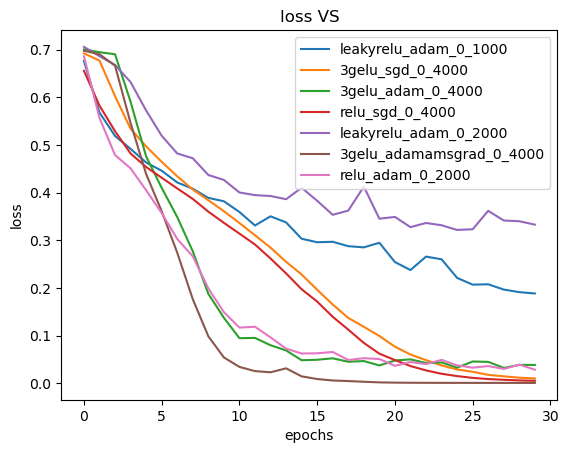

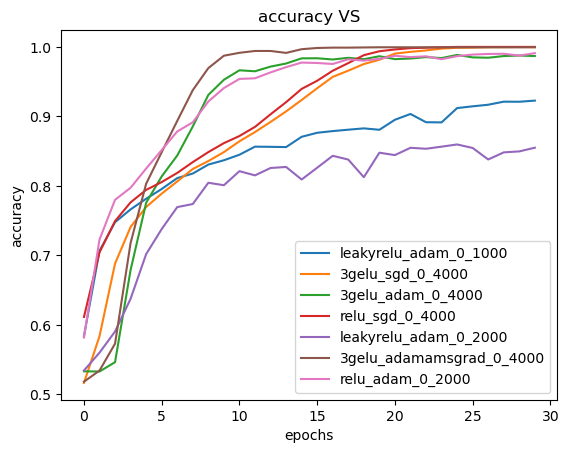

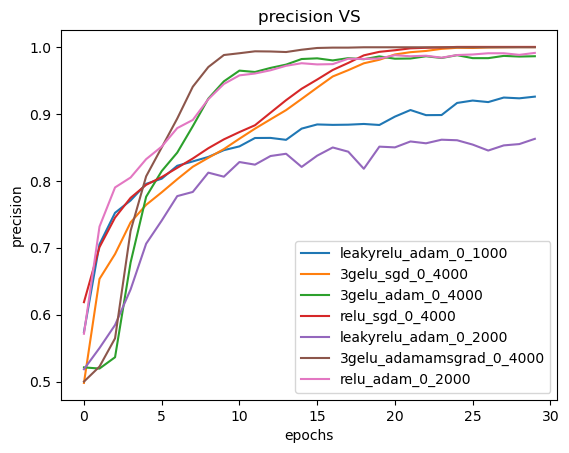

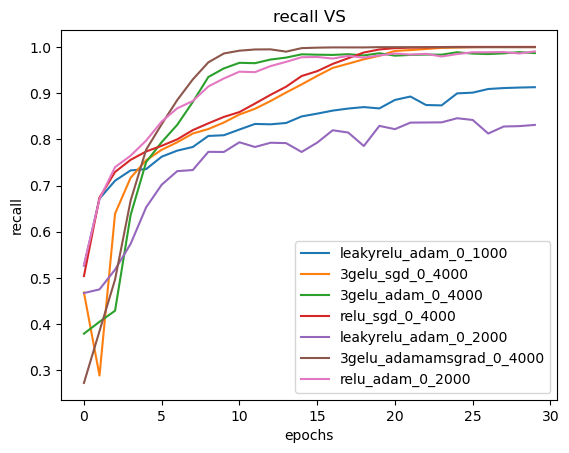

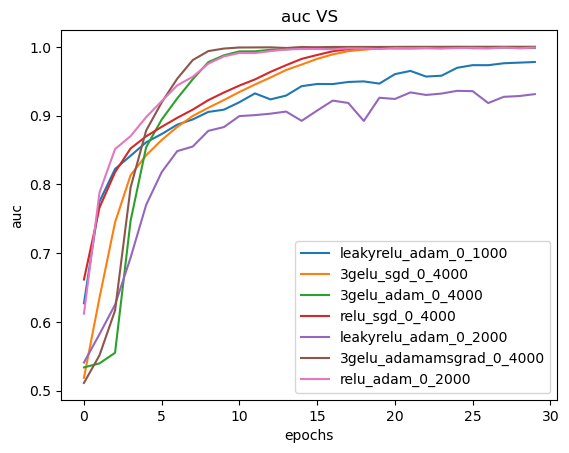

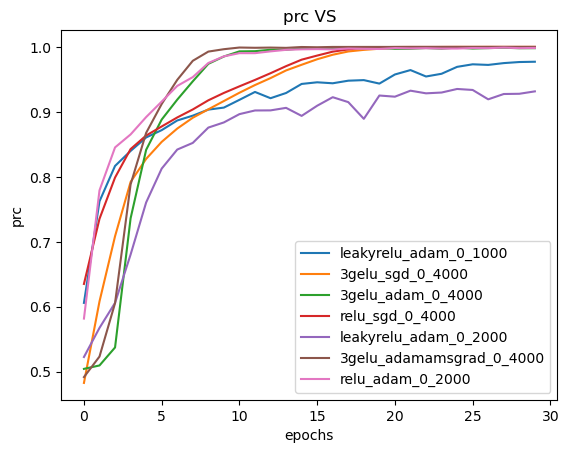

<Figure size 640x480 with 0 Axes>

In [4]:
auxua.get_histplot_from_csv(hist_path,True,run)